In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import gridspec

In [2]:
def get_events(tstamp,state, type):
    if type == "UP":
        mask = np.concatenate((np.array([False]),np.logical_and(state[1:]==1,state[1:]!=state[:-1] )))
        events = tstamp[mask]
        return events
    elif type == 'DOWN':
        mask = np.concatenate((np.array([False]),np.logical_and(state[1:]==0,state[1:]!=state[:-1] )))
        events = tstamp[mask]
        return events        
    elif type == "BOTH":
        mask = np.concatenate((np.array([False]),state[1:]!=state[:-1]))
        events = tstamp[mask]
        return events
    else:
        return None

In [3]:
def filter_data(a, lim):
    goon = True;
    while goon:
        d = np.diff(a)
        i_min = np.argmin(d)
        if d[i_min] < lim:
            goon = True
            a = np.delete(a, i_min+1)
        else:
            goon = False
    return a
    
def process_normal_data(fname, user_hz):
    pps1_events = np.array([])
    user_events = np.array([])

    data = np.genfromtxt(fname,dtype=float, delimiter=',',skip_header=1)

    raw_ts = data[:,0];
    raw_pps1 = data[:,1];
    raw_user = data[:,2];

    
    user_up = get_events(raw_ts,raw_user,'UP');
    pps_up = get_events(raw_ts,raw_pps1,'UP');
    
    first_pps_rise= pps_up[0];
    last_pps_rise = pps_up[-1];
    
    user_up = user_up[user_up > first_pps_rise];
    user_up = user_up[user_up < last_pps_rise + 0.005];
    
    user_up = filter_data(user_up,0.4*1.0/user_hz)
    pps_up = filter_data(pps_up,0.7)
    
    # pulse around pps rising edge
    user_0  = user_up[0::user_hz]

    user_delay = user_0 - pps_up;
    print "User delay at the rising PPS edge"
    plot(user_delay*1e6)
    show()

    # interpolate pps to the middle points
    x = range(0,len(pps_up))
    xuser = np.arange(0,len(user_up))/(user_hz*1.0);
    y = pps_up;
    pps1_up_interp = np.interp(xuser,x,y);

    user_delay_interp = user_up - pps1_up_interp
    print "User delay including the middle points"
    plot(user_delay_interp*1e6,'x-')
    show()

    return user_delay_interp;

def plot_distribution(dist,max_val, extra_title):
    dist_max = max(dist)
    dist_min = min(dist)
    dist_mean = np.mean(dist)
    f = figure(figsize=(8,3))
    h_min = np.floor(min(dist)*0.95);
    hist(dist,bins=np.arange(h_min,max_val,1),edgecolor='k',Color='brown')
    yscale('log')
    title('NORMAL kernel latency - %s (rtprio:80)' % extra_title)
    xlabel('Delay [us]')
    ylabel('Count')
    text(max_val*2/3,900,'Max. value:   %.2fusec\nMin. value:   %.2fusec\nMean:   %.2fusec' % (dist_max, dist_min, dist_mean), ha='left', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),  fc=(1., 0.8, 0.8)))
    grid()
    show()
    return f;  

User delay at the rising PPS edge


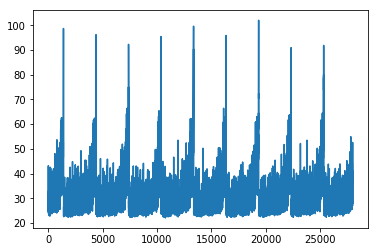

User delay including the middle points


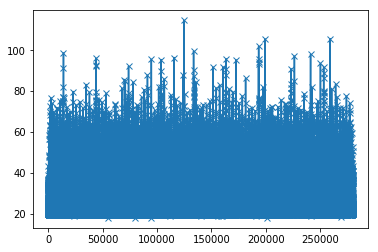

In [4]:
# results with stress
fname = './normal_kernel/no_stress/untitled2_no_stress.csv'
user_delay_no_stress = process_normal_data(fname,10)*1e6;

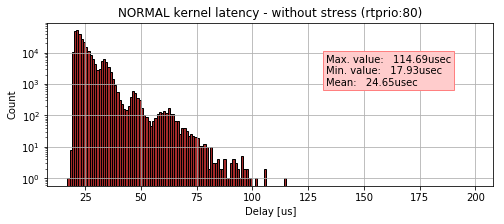

In [7]:
fig = plot_distribution(user_delay_no_stress,200, "without stress")
fig.savefig('./normal_kernel/no_stress/result',bbox_inches = "tight")
np.save('./normal_kernel/no_stress/no_stress',user_delay_no_stress);

User delay at the rising PPS edge


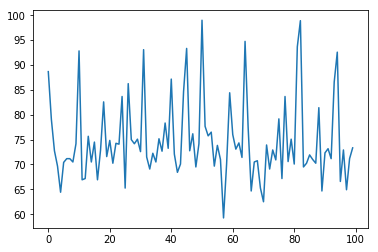

User delay including the middle points


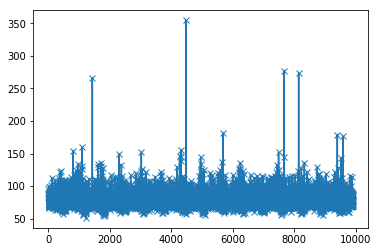

In [32]:
# results with stress
fname = './normal_kernel/stress/round2/untitled.csv'
user_delay_stress = process_normal_data(fname,100)*1e6;

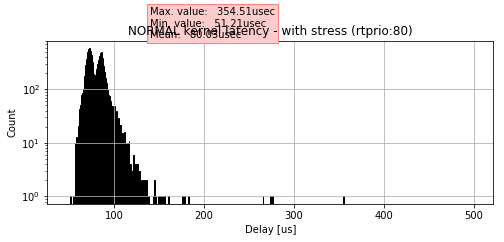

In [33]:
fig = plot_distribution(user_delay_stress, "with stress")
#fig.savefig('./preempt_rt_data/rt_stress',bbox_inches = "tight")

In [ ]:
###### round 2 eval ######

In [9]:
def process_big_data(fname, user_hz):
    pps1_events = np.array([])
    user_events = np.array([])

    with open(fname) as f:
        data = f.readlines();
        
    line_cnt = 0;
    for line in data:
        line_cnt = line_cnt+1;
        
    raw_ts = np.empty(line_cnt);
    raw_pps1 = np.empty(line_cnt);
    raw_user = np.empty(line_cnt);
    idx = 0;
    for line in data:
        tags = line.split(',');
        raw_ts[idx] = float(tags[0])
        raw_pps1[idx] = float(tags[1])
        raw_user[idx] = float(tags[2])
        idx = idx + 1;
        
    
    user_up = get_events(raw_ts,raw_user,'UP');
    pps_up = get_events(raw_ts,raw_pps1,'UP');
    
    first_pps_rise= pps_up[0];
    last_pps_rise = pps_up[-1];
    
    user_up = user_up[user_up > first_pps_rise];
    user_up = user_up[user_up < last_pps_rise + 0.005];
    
    user_up = filter_data(user_up,0.4*1.0/user_hz)
    pps_up = filter_data(pps_up,0.7)
    
    # pulse around pps rising edge
    user_0  = user_up[0::user_hz]

    user_delay = user_0 - pps_up;
    print "User delay at the rising PPS edge"
    plot(user_delay*1e6)
    show()

    # interpolate pps to the middle points
    x = range(0,len(pps_up))
    xuser = np.arange(0,len(user_up))/(user_hz*1.0);
    y = pps_up;
    pps1_up_interp = np.interp(xuser,x,y);

    user_delay_interp = user_up - pps1_up_interp
    print "User delay including the middle points"
    plot(user_delay_interp*1e6,'x-')
    show()

    return user_delay_interp;

User delay at the rising PPS edge


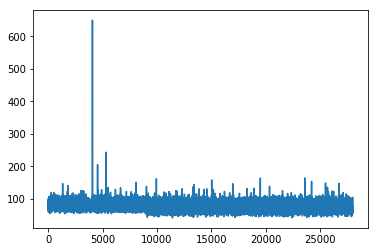

User delay including the middle points


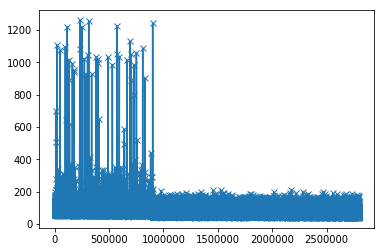

In [10]:
fname = './normal_kernel/stress/round2/untitled.csv';
user_delay_stress = process_big_data(fname,100)*1e6;

In [ ]:
# stress might have stopped somehow during the test
# plotting only the bad part

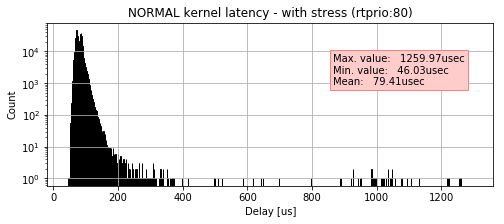

In [11]:
fig = plot_distribution(user_delay_stress[0:800000],1300, "with stress")
fig.savefig('./normal_kernel/stress/result',bbox_inches = "tight")
np.save('./normal_kernel/stress/diff_stress',user_delay_stress[0:800000])

In [24]:
# calculate upper 99 percentile
data = user_delay_stress

x_limit = np.arange(200,1300,10);
y_perc = np.empty_like(x_limit)

def calc_percentile(limit):
    global data
    cnt = data.size
    big_cnt = np.sum(data<limit)
    return big_cnt*1.0/cnt*100

y_perc = map(calc_percentile,x_limit)


81.09746665084572


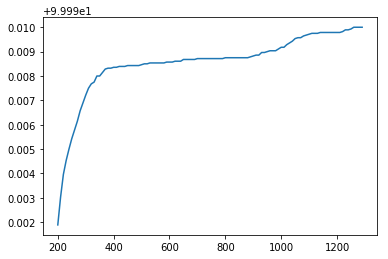

In [28]:
print (100-y_perc[0])/100*1e6
plot(x_limit,y_perc)